# Tutorial 

Based off: https://github.com/sksq96/pytorch-vae/blob/master/vae-cnn.ipynb

Data used: Sinus Endoscopy Video from https://www.youtube.com/watch?v=6niL7Poc_qQ

Simplifying Decisions:

* Downscale image to 64x64 with center crop (not perfect)

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image

from matplotlib import pyplot as plt
import numpy as np
import os
from skimage import io

%load_ext autoreload
%autoreload 2

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [3]:
#Variables
image_size=64
batch_size=64
epochs = 50
image_channels=3

In [4]:
dataset = torchvision.datasets.ImageFolder('data/surgical_video_frames/',
                                           transform=transforms.Compose([
                                                        transforms.Resize(image_size),
                                                        transforms.CenterCrop(image_size),
                                                        transforms.ToTensor(),
                                           ]))

data_loader = DataLoader(dataset=dataset,
                         batch_size=batch_size, 
                         shuffle=False)

In [5]:
# Plot the image here using matplotlib.
def plot_image(tensor):
    plt.figure()
    # imshow needs a numpy array with the channel dimension
    # as the the last dimension so we have to transpose things.
    plt.imshow(tensor.numpy().transpose(1, 2, 0))
    plt.show()

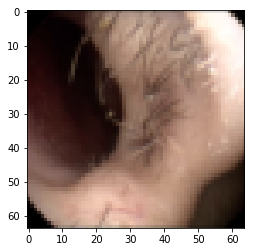

In [6]:
# Fixed input for debugging
fixed_x, _ = dataset[0]
plot_image(fixed_x)

In [7]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [8]:
class UnFlatten(nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

In [9]:
class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=32*32, z_dim=32):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten()
        )
        
        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)
        
        self.decoder = nn.Sequential(
            UnFlatten(),
            nn.ConvTranspose2d(h_dim, 128, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        # return torch.normal(mu, std)
        esp = torch.randn(*mu.size())
        z = mu + std * esp
        return z
    
    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [10]:
image_channels = fixed_x.size(0)

In [11]:
model = VAE(image_channels=3).to(device)

In [12]:
model

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2))
    (5): ReLU()
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2))
    (7): ReLU()
    (8): Flatten()
  )
  (fc1): Linear(in_features=1024, out_features=32, bias=True)
  (fc2): Linear(in_features=1024, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1024, bias=True)
  (decoder): Sequential(
    (0): UnFlatten()
    (1): ConvTranspose2d(1024, 128, kernel_size=(5, 5), stride=(2, 2))
    (2): ReLU()
    (3): ConvTranspose2d(128, 64, kernel_size=(5, 5), stride=(2, 2))
    (4): ReLU()
    (5): ConvTranspose2d(64, 32, kernel_size=(6, 6), stride=(2, 2))
    (6): ReLU()
    (7): ConvTranspose2d(32, 3, kernel_size=(6, 6), stride=(2, 2))
    (8): Sigmoid()
  )
)

In [13]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [14]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

In [ ]:
for epoch in range(epochs):
    for idx, (images, _) in enumerate(data_loader):
        recon_images, mu, logvar = model(images)
        loss, bce, kld = loss_fn(recon_images, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(epoch+1, 
                                                                    epochs, 
                                                                    loss.item()/batch_size, 
                                                                    bce.item()/batch_size, 
                                                                    kld.item()/batch_size)
        print(to_print)
        
torch.save(model.state_dict(), 'vae.torch')

Epoch[1/50] Loss: 8505.449 8505.449 0.000
Epoch[1/50] Loss: 8500.958 8500.958 0.000
Epoch[1/50] Loss: 8473.075 8473.075 0.000
Epoch[1/50] Loss: 8288.540 8288.537 0.003
Epoch[1/50] Loss: 8757.513 8757.472 0.041
Epoch[1/50] Loss: 8226.818 8226.811 0.007
Epoch[1/50] Loss: 8215.349 8215.347 0.002
Epoch[1/50] Loss: 8322.242 8322.241 0.001
Epoch[1/50] Loss: 8523.176 8523.175 0.001
Epoch[1/50] Loss: 8651.021 8651.020 0.001
Epoch[1/50] Loss: 8371.716 8371.716 0.000
Epoch[1/50] Loss: 8243.171 8243.171 0.000
Epoch[1/50] Loss: 8307.959 8307.959 0.000
Epoch[1/50] Loss: 8314.650 8314.650 0.000
Epoch[1/50] Loss: 8146.061 8146.061 0.000
Epoch[1/50] Loss: 8111.014 8111.014 0.000
Epoch[1/50] Loss: 8139.322 8139.322 0.000
Epoch[1/50] Loss: 8331.185 8331.185 0.000
Epoch[1/50] Loss: 8189.457 8189.457 0.000
Epoch[1/50] Loss: 8673.186 8673.186 0.000
Epoch[1/50] Loss: 8199.452 8199.452 0.000
Epoch[1/50] Loss: 8157.106 8157.106 0.000
Epoch[1/50] Loss: 8146.084 8146.084 0.000
Epoch[1/50] Loss: 8149.497 8149.49

In [ ]:
fixed_x = dataset[np.random.randint(1, 100)][0].unsqueeze(0)
fixed_x.size()

In [ ]:
recon_x = model(fixed_x)[0].squeeze()
recon_x.size()

In [ ]:
compare = torch.cat([fixed_x.squeeze(), recon_x], dim=2)
compare.size()

In [ ]:
plot_image(compare.detach())